In [5]:
import os

import numpy
import tensorflow as tf
import json
import pandas

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

from tools_keras import *

In [6]:
numpy.random.seed(42)

In [7]:
chips = numpy.load('../../chips_gb/multilabel_chip_64.npy')

In [8]:
chips.shape

(94960, 64, 64, 3)

In [9]:
sorter = numpy.random.choice(numpy.arange(0, len(chips)), len(chips))

In [10]:
chips = chips[sorter]

In [11]:
target = pandas.read_parquet("../../chips_gb/chip_proportions_64.pq").drop(columns="geometry").iloc[sorter]

In [12]:
target = target.drop(columns=["9_3", "9_6", "9_7", "9_8"])

In [13]:
group_mapping = [
    ['9_0', '9_1', '9_2', '9_4', '9_5'],
    ['2_0'], 
    ['2_1'], 
    ['2_2'],
    ['1_0'], 
    ['3_0'], 
    ['5_0'], 
    ['6_0'], 
    ['8_0'],
    ['0_0'],
    ['4_0'],
    ['7_0']
]

group_naming = [
    "Urbanity", 
    "Dense residential neighbourhoods",
    "Connected residential neighbourhoods",
    "Dense urban neighbourhoods",
    "Accessible suburbia",
    "Open sprawl",
    "Warehouse_Park land",
    "Gridded residential quarters",
    "Disconnected suburbia",
    "Countryside agriculture", 
    "Wild countryside", 
    "Urban buffer"
]

cd2nm = {}
for codes, name in zip(group_mapping, group_naming):
    for code in codes:
        cd2nm[f'{code}'] = name.lower().replace(" ", "_").replace("/", "_")
cd2nm = pandas.Series(cd2nm)
    
target = target.rename(columns=cd2nm).groupby(level=0, axis=1).sum()

In [14]:
mask = target.sum(axis=1) > 0.5
target_no_water = target[mask]
chips = chips[mask]

In [20]:
batch_size = 32
split1 = int(chips.shape[0] * 0.7)
split2 = int(chips.shape[0] * 0.85)


train_dataset = tf.data.Dataset.from_tensor_slices((chips[:split1], target_no_water.values[:split1]))
test_dataset = tf.data.Dataset.from_tensor_slices((chips[split1:split2], target_no_water.values[split1:split2]))
secret_dataset = tf.data.Dataset.from_tensor_slices((chips[split2:], target_no_water.values[split2:]))

train_dataset = train_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)
secret_dataset = secret_dataset.batch(batch_size=batch_size)

In [12]:
preprocessing_and_augmentation = keras.Sequential(
    [
        layers.Resizing(224, 224, crop_to_aspect_ratio=True),
    ]
)

In [45]:
base_model = keras.applications.EfficientNetB4(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False, # Do not include the ImageNet classifier at the top.
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(64, 64, 3))
x = preprocessing_and_augmentation(inputs)
x = preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(12, activation="sigmoid")(x)

model = keras.Model(inputs, predictions)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_3   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               229504    
                                                                 
 dense_7 (Dense)             (None, 12)                1548      
                                                           

In [46]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mean_squared_error", "accuracy"],
)

<AxesSubplot:>

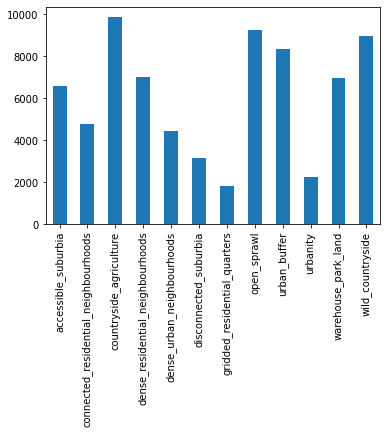

In [22]:
target.sum().plot.bar()

In [23]:
weights = target.sum().max() / target.sum()

In [24]:
class_weights = {k:w for k, w in enumerate(weights.values)}

In [47]:
specs = {
    "folder": "../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/"

}

model_folder = specs['folder'] + "model"
log_folder = specs['folder'] + "logs"
pred_folder = specs['folder'] + "pred"
json_folder = specs['folder'] + "json"

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, min_delta=0.02, verbose=True),
    ModelCheckpoint(
        filepath=f"{model_folder}/{model.name}_best",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
    ),
    TensorBoard(log_dir=os.path.join(log_folder, model.name), histogram_freq=1)
]

In [48]:
t0 = time.time()

epochs = 200
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, class_weight=class_weights, callbacks=callbacks,)

t1 = time.time()
specs["runtime"] = t1 - t0

Epoch 1/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0597 - mean_squared_error: 0.0381 - accuracy: 0.3986INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 274s 164ms/step - loss: 0.0597 - mean_squared_error: 0.0381 - accuracy: 0.3986 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_accuracy: 0.4326
Epoch 2/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0502 - mean_squared_error: 0.0331 - accuracy: 0.4858INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 264s 164ms/step - loss: 0.0502 - mean_squared_error: 0.0331 - accuracy: 0.4858 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_accuracy: 0.4709
Epoch 3/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0446 - mean_squared_error: 0.0302 - accuracy: 0.5423INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 263s 163ms/step - loss: 0.0446 - mean_squared_error: 0.0302 - accuracy: 0.5423 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_accuracy: 0.5307
Epoch 4/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0399 - mean_squared_error: 0.0275 - accuracy: 0.5937INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 265s 164ms/step - loss: 0.0399 - mean_squared_error: 0.0275 - accuracy: 0.5937 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_accuracy: 0.5622
Epoch 5/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0359 - mean_squared_error: 0.0251 - accuracy: 0.6355INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 266s 165ms/step - loss: 0.0359 - mean_squared_error: 0.0251 - accuracy: 0.6355 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_accuracy: 0.5921
Epoch 6/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0230 - accuracy: 0.6742INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 265s 164ms/step - loss: 0.0326 - mean_squared_error: 0.0230 - accuracy: 0.6742 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_accuracy: 0.6127
Epoch 7/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0298 - mean_squared_error: 0.0211 - accuracy: 0.7029INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 264s 164ms/step - loss: 0.0298 - mean_squared_error: 0.0211 - accuracy: 0.7029 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_accuracy: 0.6359
Epoch 8/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0273 - mean_squared_error: 0.0195 - accuracy: 0.7277INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 266s 165ms/step - loss: 0.0273 - mean_squared_error: 0.0195 - accuracy: 0.7277 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_accuracy: 0.6533
Epoch 9/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0253 - mean_squared_error: 0.0181 - accuracy: 0.7479INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 265s 164ms/step - loss: 0.0253 - mean_squared_error: 0.0181 - accuracy: 0.7479 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_accuracy: 0.6666
Epoch 10/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0236 - mean_squared_error: 0.0168 - accuracy: 0.7651INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 267s 165ms/step - loss: 0.0236 - mean_squared_error: 0.0168 - accuracy: 0.7651 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_accuracy: 0.6792
Epoch 11/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0221 - mean_squared_error: 0.0157 - accuracy: 0.7790INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 266s 165ms/step - loss: 0.0221 - mean_squared_error: 0.0157 - accuracy: 0.7790 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_accuracy: 0.6883
Epoch 12/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0208 - mean_squared_error: 0.0148 - accuracy: 0.7933INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 265s 164ms/step - loss: 0.0208 - mean_squared_error: 0.0148 - accuracy: 0.7933 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_accuracy: 0.6941
Epoch 13/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0196 - mean_squared_error: 0.0139 - accuracy: 0.8047INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 266s 165ms/step - loss: 0.0196 - mean_squared_error: 0.0139 - accuracy: 0.8047 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_accuracy: 0.7053
Epoch 14/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0186 - mean_squared_error: 0.0132 - accuracy: 0.8143INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 265s 165ms/step - loss: 0.0186 - mean_squared_error: 0.0132 - accuracy: 0.8143 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_accuracy: 0.7105
Epoch 15/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.0125 - accuracy: 0.8218INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 266s 165ms/step - loss: 0.0177 - mean_squared_error: 0.0125 - accuracy: 0.8218 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_accuracy: 0.7148
Epoch 16/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.0119 - accuracy: 0.8287INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 266s 165ms/step - loss: 0.0170 - mean_squared_error: 0.0119 - accuracy: 0.8287 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_accuracy: 0.7309
Epoch 17/200
1613/1613 [==============================] - 212s 131ms/step - loss: 0.0162 - mean_squared_error: 0.0114 - accuracy: 0.8349 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_accuracy: 0.7299
Epoch 18/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0157 - mean_squared_error: 0.0110 - accuracy: 0.8407INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 267s 165ms/step - loss: 0.0157 - mean_squared_error: 0.0110 - accuracy: 0.8407 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_accuracy: 0.7320
Epoch 19/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.0105 - accuracy: 0.8451INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 266s 165ms/step - loss: 0.0151 - mean_squared_error: 0.0105 - accuracy: 0.8451 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_accuracy: 0.7326
Epoch 20/200
1613/1613 [==============================] - ETA: 0s - loss: 0.0146 - mean_squared_error: 0.0101 - accuracy: 0.8487INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3_best/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1613/1613 [==============================] - 266s 165ms/step - loss: 0.0146 - mean_squared_error: 0.0101 - accuracy: 0.8487 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_accuracy: 0.7406
Epoch 21/200
1613/1613 [==============================] - 212s 131ms/step - loss: 0.0141 - mean_squared_error: 0.0098 - accuracy: 0.8532 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_accuracy: 0.7380
Epoch 00021: early stopping


In [49]:
model.save(f"{model_folder}/{model.name}", save_format="tf")

INFO:tensorflow:Assets written to: ../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/model/model_3/assets


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [50]:
nn = "efficinetnet"
bridge = "pooling"
toplayer = "softmax"
n_class = 12

meta = {
    # Metadata about run
    "meta_n_class": n_class,
    "meta_class_map": group_mapping,
    "meta_class_names": group_naming,
    "meta_chip_size": 64,
    # Model
    "model_name": model.name,
    "model_bridge": bridge,
    "model_toplayer": toplayer,
}
meta["meta_runtime"] = specs["runtime"]

subsets = {
    "train": train_dataset,
    "val": test_dataset,
    "secret": secret_dataset,
}
labels = {
    "train": numpy.argmax(target_no_water.values[:split1], axis=1),
    "val": numpy.argmax(target_no_water.values[split1:split2], axis=1),
    "secret": numpy.argmax(target_no_water.values[split2:], axis=1),
}
# Performance
for subset in subsets:
    print(f"assessing performance of {subset} dataset")
    dataset = subsets[subset]
    y_pred_probs = model.predict(dataset)

    os.makedirs(pred_folder, exist_ok=True)
    np.save(os.path.join(pred_folder, model.name + f"_{subset}.npy"), y_pred_probs)
    print(f"prediction of {subset} saved")
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    y = labels[subset]
    top_prob, wc_accuracy, wc_top_prob = within_class_metrics(
        y, y_pred, y_pred_probs
    )
    # Accuracy
    meta[f"perf_model_accuracy_{subset}"] = accuracy(y, y_pred)
    # Prob for top class
    meta[f"perf_avg_prob_top_{subset}"] = top_prob
    # Within-class accuracy
    meta[f"perf_within_class_accuracy_{subset}"] = wc_accuracy
    # Within-class avg. prob for top class
    meta[f"perf_within_class_avg_prob_top_{subset}"] = wc_top_prob
    # Full confusion matrix
    meta[f"perf_confusion_{subset}"] = confusion_matrix(y, y_pred, int(n_class))
    print(
        f"perf_model_accuracy for {subset}: {meta[f'perf_model_accuracy_{subset}']}"
    )

os.makedirs(json_folder, exist_ok=True)
with open(
    os.path.join(json_folder, model.name + ".json"), "w", encoding="utf-8"
) as f:
    f.write(json.dumps(meta, indent=4, cls=NumpyEncoder).replace("NaN", "null"))

assessing performance of train dataset
prediction of train saved
perf_model_accuracy for train: 0.8380683064460754
assessing performance of val dataset
prediction of val saved
perf_model_accuracy for val: 0.738017737865448
assessing performance of secret dataset
prediction of secret saved
perf_model_accuracy for secret: 0.7360281944274902


See the probability distributions for secret

<AxesSubplot:ylabel='Frequency'>

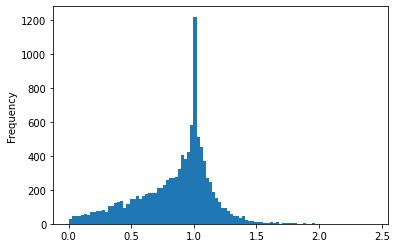

In [51]:
pandas.Series(y_pred_probs.sum(axis=1)).plot.hist(bins=100)

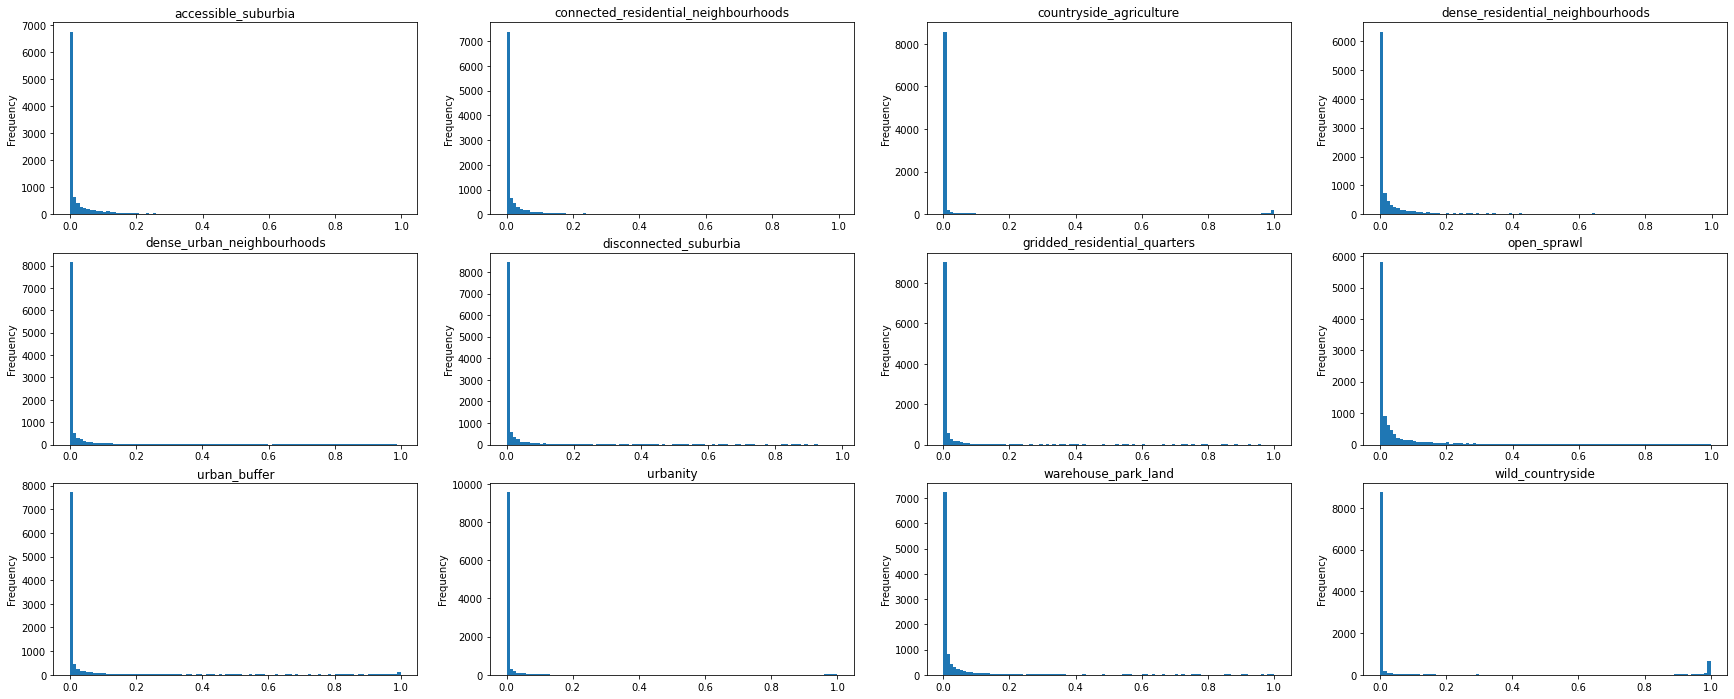

In [52]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(30, 12))
for i, (n, ax) in enumerate(zip(target.columns, axs.flatten())):
    pandas.Series(y_pred_probs[:, i]).plot.hist(bins=100, ax=ax)
    ax.set_title(n)

In [53]:
conf = confusion_matrix(y, y_pred, 12)

In [54]:
target.columns

Index(['accessible_suburbia', 'connected_residential_neighbourhoods',
       'countryside_agriculture', 'dense_residential_neighbourhoods',
       'dense_urban_neighbourhoods', 'disconnected_suburbia',
       'gridded_residential_quarters', 'open_sprawl', 'urban_buffer',
       'urbanity', 'warehouse_park_land', 'wild_countryside'],
      dtype='object')

([<matplotlib.axis.YTick at 0x7f586248c670>,
 [Text(0, 0, 'urbanity'),
  Text(0, 1, 'dense_urban_neighbourhoods'),
  Text(0, 2, 'dense_residential_neighbourhoods'),
  Text(0, 3, 'connected_residential_neighbourhoods'),
  Text(0, 4, 'gridded_residential_quarters'),
  Text(0, 5, 'accessible_suburbia'),
  Text(0, 6, 'disconnected_suburbia'),
  Text(0, 7, 'open_sprawl'),
  Text(0, 8, 'warehouse_park_land'),
  Text(0, 9, 'urban_buffer'),
  Text(0, 10, 'countryside_agriculture'),
  Text(0, 11, 'wild_countryside')])

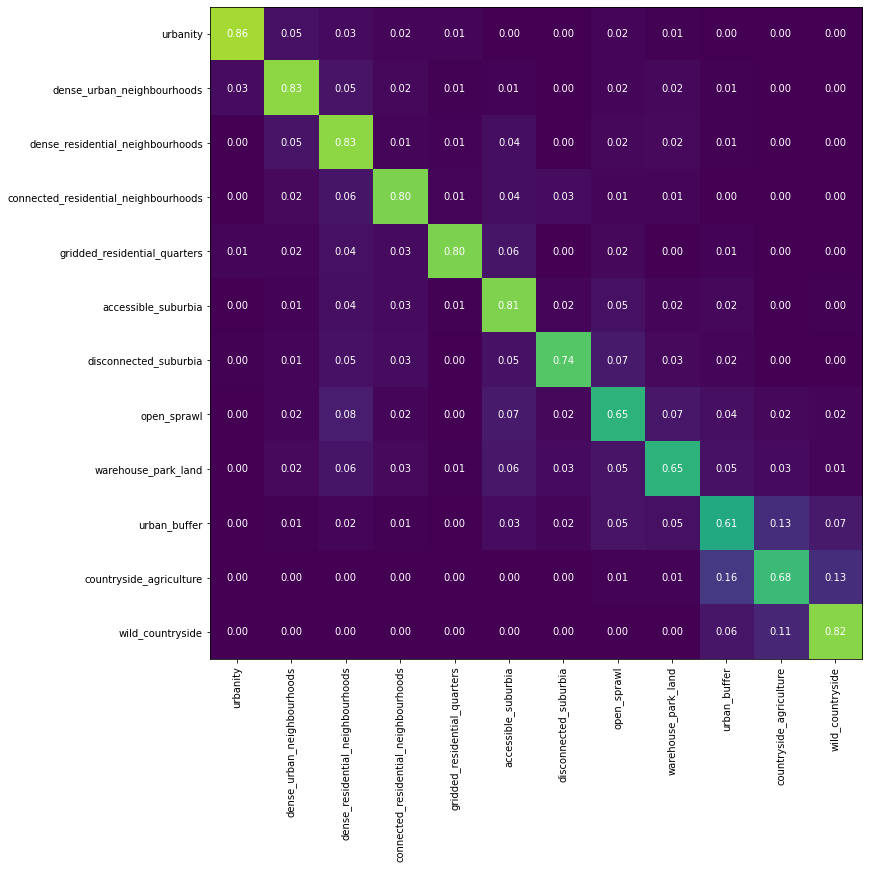

In [55]:
from itertools import product

fig, ax = plt.subplots(figsize=(12, 12))
order = numpy.array([9, 4, 3, 1, 6, 0, 5, 7, 10, 8, 2, 11], dtype=int)
a = pandas.DataFrame(conf).iloc[order, order].values
a = a / a.sum(axis=1)[:, numpy.newaxis]
a = pandas.DataFrame(a).values
ax.imshow(a, cmap="viridis", vmin=0, vmax=1)
for k, j in product(range(12), range(12)):
    ax.text(j, k, "{:.2f}".format(a[k, j]),
                   ha="center", va="center", color="w")
ticks = target.columns[order]
plt.xticks(range(12),ticks, rotation=90)
plt.yticks(range(12),ticks)


No class weights

In [34]:
base_model = keras.applications.EfficientNetB4(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False, # Do not include the ImageNet classifier at the top.
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(64, 64, 3))
x = preprocessing_and_augmentation(inputs)
x = preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(12, activation="sigmoid")(x)

model = keras.Model(inputs, predictions)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               229504    
                                                                 
 dense_5 (Dense)             (None, 12)                1548      
                                                           

In [35]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mean_squared_error", "accuracy"],
)

In [36]:
epochs = 5
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/5
1613/1613 [==============================] - 215s 130ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - accuracy: 0.4181 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_accuracy: 0.4609
Epoch 2/5
1613/1613 [==============================] - 208s 129ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - accuracy: 0.5065 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_accuracy: 0.5070
Epoch 3/5
1613/1613 [==============================] - 208s 129ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - accuracy: 0.5712 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_accuracy: 0.5575
Epoch 4/5
1613/1613 [==============================] - 208s 129ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - accuracy: 0.6293 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_accuracy: 0.5995
Epoch 5/5
1613/1613 [==============================] - 208s 129ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - accuracy: 0.6754 - val_loss: 0.0263 - val_mean_

In [37]:
y_pred_probs_no_w = model.predict(test_dataset)
y_pred_no_w = numpy.argmax(y_pred_probs_no_w, axis=1)

In [38]:
accuracy(y, y_pred_no_w)

0.09685296

In [39]:
conf = confusion_matrix(y, y_pred_no_w, 12)

([<matplotlib.axis.YTick at 0x7f597b8dc5e0>,
 [Text(0, 0, 'accessible_suburbia'),
  Text(0, 1, 'connected_residential_neighbourhoods'),
  Text(0, 2, 'countryside_agriculture'),
  Text(0, 3, 'dense_residential_neighbourhoods'),
  Text(0, 4, 'dense_urban_neighbourhoods'),
  Text(0, 5, 'disconnected_suburbia'),
  Text(0, 6, 'gridded_residential_quarters'),
  Text(0, 7, 'open_sprawl'),
  Text(0, 8, 'urban_buffer'),
  Text(0, 9, 'urbanity'),
  Text(0, 10, 'warehouse_park_land'),
  Text(0, 11, 'wild_countryside')])

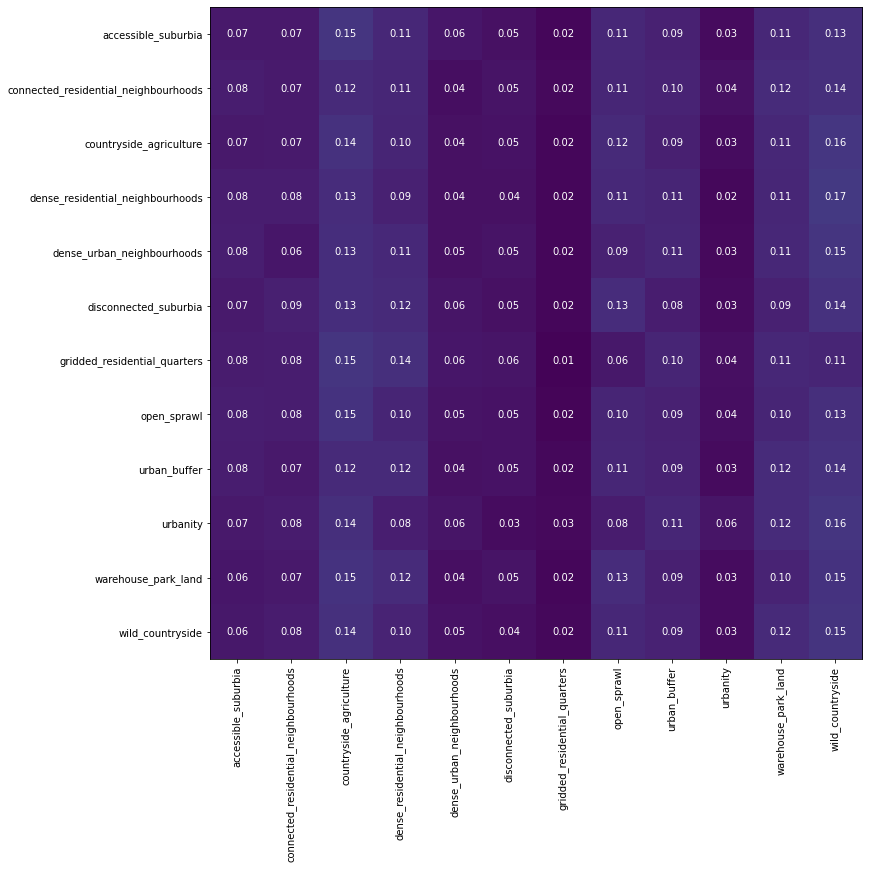

In [40]:
from itertools import product

fig, ax = plt.subplots(figsize=(12, 12))
a = conf
a = a / (a.sum(axis=1) + 0.000000001)[:, numpy.newaxis]
a = pandas.DataFrame(a).values
ax.imshow(a, cmap="viridis", vmin=0, vmax=1)
for k, j in product(range(12), range(12)):
    ax.text(j, k, "{:.2f}".format(a[k, j]),
                   ha="center", va="center", color="w")
plt.xticks(range(12),target.columns, rotation=90)
plt.yticks(range(12),target.columns)


<AxesSubplot:ylabel='Frequency'>

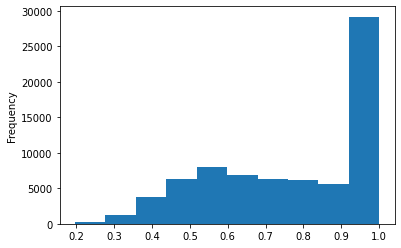

In [16]:
target_no_water.max(axis=1).plot.hist()

In [17]:
prediction = numpy.load("../../urbangrammar_samba/spatial_signatures/ai/gb_64_multiclass/pred/model_3_val.npy")

In [22]:
prediction.shape

(11058, 12)

In [26]:
labels = target_no_water.iloc[split1:split2]

In [27]:
labels.shape

(11058, 12)

In [28]:
single = labels.max(axis=1) == 1
labels_single = labels[single]

<AxesSubplot:ylabel='Frequency'>

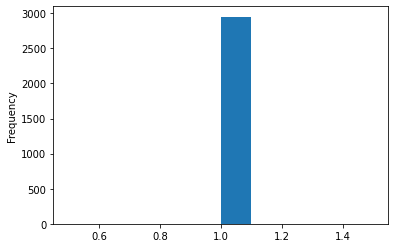

In [29]:
labels_single.max(axis=1).plot.hist()

In [30]:
pred_labels = numpy.argmax(prediction[single], axis=1)